In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision
import os
from PIL import Image
import random
from tqdm import tqdm

d:\Conda\envs\NLP\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Nie można odnaleźć określonej procedury'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
IMG_DIMS = (256, 256)
BATCH_SIZE = 16

# Dataset info
TRUTH = "Ground_truth"
NOISY = "Noisy_folder"

In [3]:
noisy_images_folder = os.listdir(NOISY)

In [4]:
zipped_paths = []
for truth_image_path in os.listdir(TRUTH):
    noisy_image_path = f"{NOISY}/noisy_{truth_image_path}"
    truth_image_path = f"{TRUTH}/{truth_image_path}"
    zipped_paths.append([noisy_image_path, truth_image_path])

In [5]:
zipped_paths[:5]

[['Noisy_folder/noisy_10961455225_0786d3edd2_c.jpg',
  'Ground_truth/10961455225_0786d3edd2_c.jpg'],
 ['Noisy_folder/noisy_1110822219_a079aeff30_c.jpg',
  'Ground_truth/1110822219_a079aeff30_c.jpg'],
 ['Noisy_folder/noisy_11905744206_c9273e7489_c.jpg',
  'Ground_truth/11905744206_c9273e7489_c.jpg'],
 ['Noisy_folder/noisy_11957512115_382fbccc03_c.jpg',
  'Ground_truth/11957512115_382fbccc03_c.jpg'],
 ['Noisy_folder/noisy_127215712_ff5b654d07_c.jpg',
  'Ground_truth/127215712_ff5b654d07_c.jpg']]

In [6]:
class DefoccusedAndMotionBluredDataset(Dataset):
    def __init__(self, data, transforms) -> None:
        super().__init__()
        self.ln = len(data)
        self.data = data
        self.transforms = transforms
    
    def __len__(self):
        return self.ln
        
    def __getitem__(self, index):
        defocused, sharp = self.data[index]
        
        defocused = Image.open(defocused)
        sharp = Image.open(sharp)
        
        return self.transforms(defocused), self.transforms(sharp)

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IMG_DIMS),
    torchvision.transforms.ToTensor(),
])

In [8]:
ds = DefoccusedAndMotionBluredDataset(zipped_paths, transforms)
dataloader = DataLoader(ds, BATCH_SIZE, True)

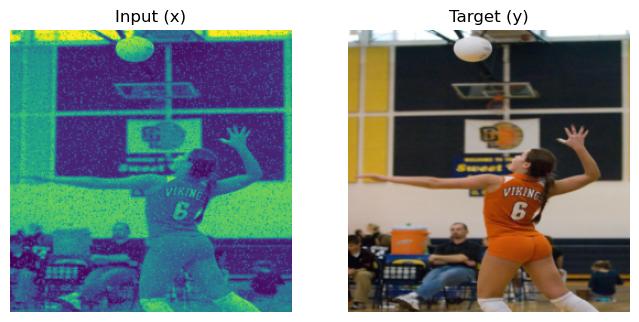

In [9]:
x, y = next(iter(dataloader))

index = 0

# Convert tensor to numpy array and permute dimensions to (H, W, C)
x_sample = x[index].permute(1, 2, 0).numpy()
y_sample = y[index].permute(1, 2, 0).numpy()

# Plot the images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_sample)
plt.title("Input (x)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(y_sample)
plt.title("Target (y)")
plt.axis("off")

plt.show()

In [10]:
class EncoderBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(inp, out, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out),
            nn.AvgPool2d(2),
        )
    
    def forward(self, x):
        return self.layers(x)

In [11]:
class DecoderBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(inp, out, 3, 1, 1),
            nn.BatchNorm2d(out),
            nn.LeakyReLU(),
        )
    
    def forward(self, x):
        return self.layers(x)

In [12]:
class Denoiser(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        
        self.encoder_block1 = EncoderBlock(channels, channels)
        self.encoder_block2 = EncoderBlock(channels, channels)
        self.encoder_block3 = EncoderBlock(channels, channels)
        self.encoder_block4 = EncoderBlock(channels, channels)
        self.encoder_block5 = EncoderBlock(channels, channels)
        
        self.dencoder_block1 = DecoderBlock(channels, channels)
        self.dencoder_block2 = DecoderBlock(channels, channels)
        self.dencoder_block3 = DecoderBlock(channels, channels)
        self.dencoder_block4 = DecoderBlock(channels, channels)
        self.dencoder_block5 = DecoderBlock(channels, channels)
        
        self.first_conv = nn.Conv2d(1, channels, 1)
        self.finish_conv = nn.Conv2d(channels, 3, 1)
        
    def forward(self, x):
        
        fs = self.first_conv(x)
        eout1 = self.encoder_block1(fs) # 128
        eout2 = self.encoder_block2(eout1) # 64
        eout3 = self.encoder_block3(eout2) # 32
        eout4 = self.encoder_block4(eout3) # 16
        eout5 = self.encoder_block5(eout4) # 8
        
        dout1 = self.dencoder_block1(eout5) # 16
        dout1 += eout4
        
        dout2 = self.dencoder_block2(dout1) # 32
        dout2 += eout3
        
        dout3 = self.dencoder_block3(dout2) # 64
        dout3 += eout2
        
        dout4 = self.dencoder_block4(dout3) # 128
        dout4 += eout1
        
        dout5 = self.dencoder_block4(dout4) # 256
        dout5 += fs

        return self.finish_conv(dout5)

In [13]:
class DenoiserMod:
    def __init__(self, dataloader: DataLoader, channels: int = 128, epochs: int = 100):
        self.dataloader = dataloader
        
        self.model = Denoiser(channels)
        self.optimizer = Adam(self.model.parameters())
        
        self.epochs = epochs
        
        self.criterion = nn.MSELoss()
        
        self.device = ("cuda" if torch.cuda.is_available() else "cpu")
        print("Training on:", self.device)
        
        self.model.to(self.device)
    
    def train(self):
        for epoch in range(self.epochs):
            for x, y in tqdm(self.dataloader):
                x = x.to(self.device)
                y = y.to(self.device)
                
                self.optimizer.zero_grad()
                self.model.train()
                
                out = self.model(x)
                loss = self.criterion(out, y)

                
                loss.backward()
                self.optimizer.step()
            
            torch.save(self.model, "denoiser.h5")
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {loss.item()}")
            self.sample()
    
    def sample(self):
        ln = len(self.dataloader.dataset)
        random_index = random.randint(0, ln - 1)
        x, y = self.dataloader.dataset[random_index]
        
        columns = 1
        rows = 3
        
        titles = ["Noise Image", "Model Output", "Ground Truth"]
        
        self.model.eval()
        with torch.no_grad():
            print(x.shape)
            deblurred = self.model(x.unsqueeze(0).to(self.device))
        
        if deblurred.dim() == 4:
            deblurred = deblurred.squeeze(0)
        
        deblurred = deblurred.detach().cpu().permute(1, 2, 0).numpy()
        x = x.permute(1, 2, 0).numpy()
        y = y.permute(1, 2, 0).numpy()
        
        fig = plt.figure(figsize=(15, 15))
        cnt = 0
        for i in range(1, 4):
            fig.add_subplot(columns, rows, i)
            plt.title(titles[cnt])
            if cnt == 0:  # Wyświetl wejściowy rozmyty obraz
                plt.imshow(x)
            elif cnt == 1:  # Wyświetl deblurowany obraz
                plt.imshow(deblurred)
            else:  # Wyświetl ostry obraz referencyjny
                plt.imshow(y)
            plt.axis("off")
            cnt += 1
            
        plt.show()

In [14]:
deblurrer = DenoiserMod(dataloader)

Training on: cuda


torch.Size([1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


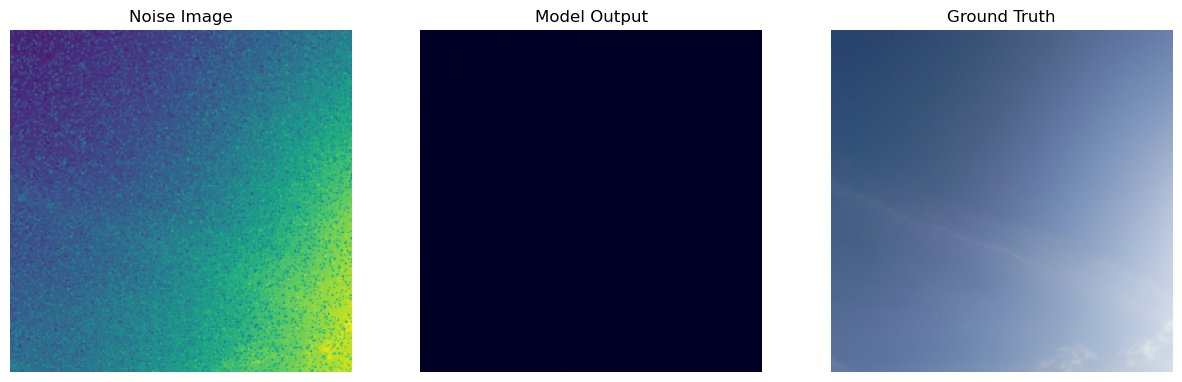

In [15]:
deblurrer.sample()

100%|██████████| 19/19 [01:01<00:00,  3.24s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/100], Loss: 0.03921866416931152
torch.Size([1, 256, 256])


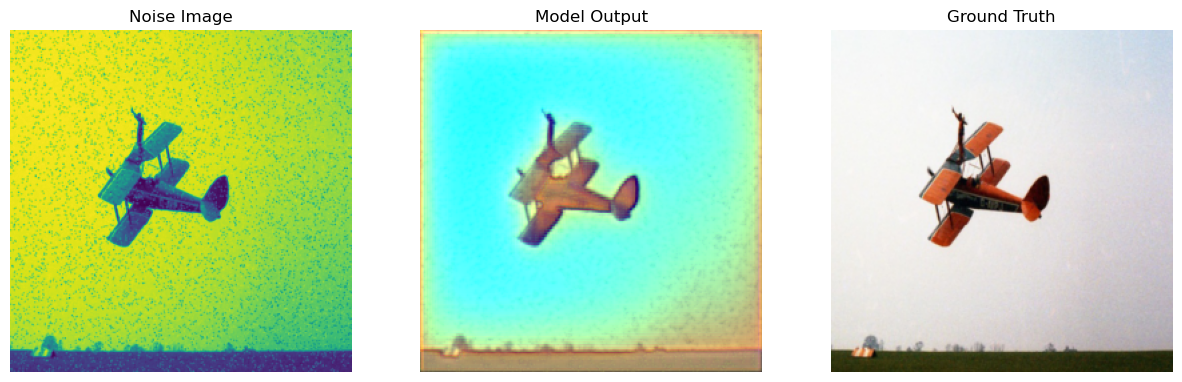

100%|██████████| 19/19 [00:53<00:00,  2.81s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/100], Loss: 0.009684824384748936
torch.Size([1, 256, 256])


100%|██████████| 19/19 [01:00<00:00,  3.20s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/100], Loss: 0.014743027277290821
torch.Size([1, 256, 256])


100%|██████████| 19/19 [00:33<00:00,  1.77s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/100], Loss: 0.014036859385669231
torch.Size([1, 256, 256])


100%|██████████| 19/19 [00:33<00:00,  1.76s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [5/100], Loss: 0.010596485808491707
torch.Size([1, 256, 256])


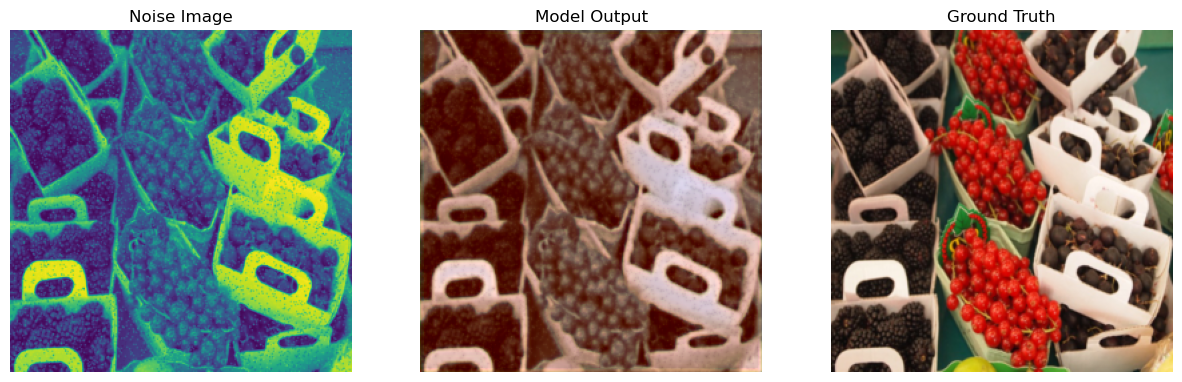

100%|██████████| 19/19 [00:33<00:00,  1.76s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [6/100], Loss: 0.016226554289460182
torch.Size([1, 256, 256])


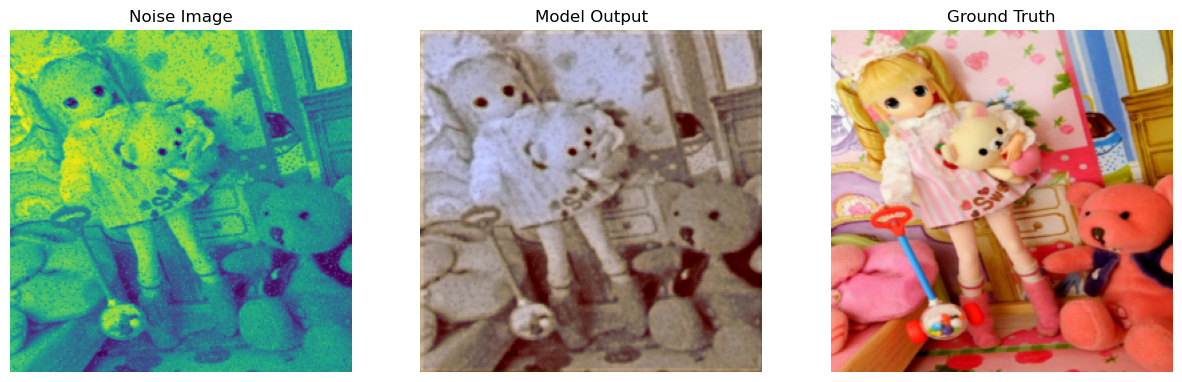

100%|██████████| 19/19 [00:33<00:00,  1.77s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [7/100], Loss: 0.01340667437762022
torch.Size([1, 256, 256])


100%|██████████| 19/19 [00:33<00:00,  1.78s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [8/100], Loss: 0.014088137075304985
torch.Size([1, 256, 256])


 11%|█         | 2/19 [00:02<00:21,  1.29s/it]

In [16]:
deblurrer.train()